In [1]:
from Bio import SeqIO

In [2]:
# genome_file = "../data/ecoli.genbank"
# genome_file_type = genome_file.split('.')[-1]

genome_file = "../data/ecoli.genbank"
genome_file_type = genome_file.split('.')[-1]

In [3]:
iterator = SeqIO.parse(genome_file, genome_file_type)
record = next(iterator)
length = len(record.seq)
print("read seq from file {}, length = {}".format(genome_file, length))

read seq from file ../data/ecoli.genbank, length = 4641652


In [4]:
import numpy as np
bases_dict     = {"A": 0, "T": 1, "C": 2, "G": 3}
bases_list = ["A", "T", "C", "G"]
bases_np        = {
                    "A": np.array([1, 0, 0, 0], dtype = np.float32),
                    "T": np.array([0, 1, 0, 0], dtype = np.float32),
                    "C": np.array([0, 0, 1, 0], dtype = np.float32),
                    "G": np.array([0, 0, 0, 1], dtype = np.float32)
                    }

seq_np = np.zeros((length, 4), dtype = np.float32) 
for index in range(length):
    base = record.seq[index]
    if base in bases_list:
        channel = bases_dict[base]
        seq_np[index, channel] = 1
    else:
        print("alternative base")

In [5]:
seq_np.shape

(4641652, 4)

In [6]:
test = 0.1
train_ids = np.random.choice(int(length * (1-test)) - 300, 10000) + 200
test_ids = np.random.choice(int(length * test) - 300, 1000) + int(length * (1-test))

In [7]:
print(len(train_ids), min(train_ids), max(train_ids))
print(len(test_ids), min(test_ids), max(test_ids))

10000 552 4177340
1000 4178236 4641246


In [8]:
LENGTH = 100
train1 = np.array([seq_np[x-LENGTH:x, ...] for x in train_ids])
train2 = np.array([seq_np[x+1:x+LENGTH+1, ...] for x in train_ids])
train_ans = np.array([seq_np[x, ...]  for x in train_ids])

test1 = np.array([seq_np[x-LENGTH:x, ...] for x in test_ids])
test2 = np.array([seq_np[x+1:x+LENGTH+1, ...] for x in test_ids])
test_ans = np.array([seq_np[x, ...]  for x in test_ids])

In [9]:
print(train1.shape, train2.shape, train_ans.shape)
print( test1.shape, test2.shape, test_ans.shape)

(10000, 100, 4) (10000, 100, 4) (10000, 4)
(1000, 100, 4) (1000, 100, 4) (1000, 4)


In [31]:
# import tensorflow as tf
# sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

In [32]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense, Input
from keras.layers.normalization import BatchNormalization
from keras.models import Model


def build_half_model():
    model = Sequential()
    
    model.add(Conv1D(32, kernel_size=(3), input_shape=(LENGTH, 4)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPooling1D(pool_size=(2)))
    
    model.add(Conv1D(16, kernel_size=(3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling1D(pool_size=(2)))
    
    model.add(Conv1D(8, kernel_size=(3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(MaxPooling1D(pool_size=(2)))
    
    model.add(Conv1D(8, kernel_size=(3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Conv1D(8, kernel_size=(3)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    
    return model

def create_model():
    half1 = build_half_model()
    half2 = build_half_model()

    cur_layer = keras.layers.concatenate([half1.output, half2.output])

    cur_layer = Flatten()(cur_layer)
    cur_layer = Dense(8)(cur_layer)
    cur_layer = Activation('relu')(cur_layer)
    cur_layer = Dropout(0.4)(cur_layer)

    cur_layer = Dense(8)(cur_layer)
    cur_layer = Activation('relu')(cur_layer)
    cur_layer = Dropout(0.4)(cur_layer)

    cur_layer = Dense(4, kernel_initializer='normal', activation='sigmoid')(cur_layer)
    
    model = Model([half1.input, half2.input], cur_layer)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = create_model()
# model.summary()

In [17]:
model.evaluate([test1, test2], test_ans)

1000/1000 [==============================] - 2s 2ms/step


[1.3862682170867919, 0.25800000000000001]

In [ ]:
model.evaluate([train1, train2], train_ans)

10000/10000 [==============================] - 5s 506us/step


[1.3862791316986085, 0.2495]

In [26]:
history = model.fit([train1, train2], train_ans, epochs=100, validation_split = 0.1)   

Train on 9000 samples, validate on 1000 samples
Epoch 1/100
9000/9000 [==============================] - 20s 2ms/step - loss: 1.1336 - acc: 0.4533 - val_loss: 1.8540 - val_acc: 0.2690
Epoch 2/100
9000/9000 [==============================] - 19s 2ms/step - loss: 1.1240 - acc: 0.4639 - val_loss: 1.8352 - val_acc: 0.2580
Epoch 3/100
9000/9000 [==============================] - 20s 2ms/step - loss: 1.1241 - acc: 0.4667 - val_loss: 1.8276 - val_acc: 0.2490
Epoch 4/100
9000/9000 [==============================] - 20s 2ms/step - loss: 1.1180 - acc: 0.4668 - val_loss: 1.8120 - val_acc: 0.2560
Epoch 5/100
9000/9000 [==============================] - 20s 2ms/step - loss: 1.1110 - acc: 0.4691 - val_loss: 1.9211 - val_acc: 0.2620
Epoch 6/100
9000/9000 [==============================] - 19s 2ms/step - loss: 1.1192 - acc: 0.4650 - val_loss: 1.8836 - val_acc: 0.2710
Epoch 7/100
9000/9000 [==============================] - 20s 2ms/step - loss: 1.1125 - acc: 0.4696 - val_loss: 1.9701 - val_acc: 0.2570


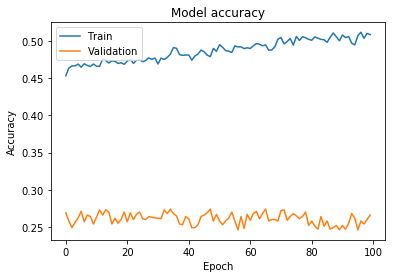

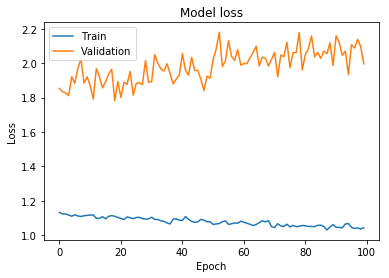

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [28]:
print(model.evaluate([train1, train2], train_ans))
print(model.evaluate([test1, test2], test_ans))

10000/10000 [==============================] - 5s 498us/step
[1.0847143198013305, 0.51139999999999997]
1000/1000 [==============================] - 1s 522us/step
[2.0490440807342529, 0.251]


In [29]:
np.mean(history.history['val_acc'])

0.26097000000000004

In [30]:
np.std(history.history['val_acc'])

0.0075451375070306114